### Prompt engineering for Llama-3-8B-Instruct psychophysics

In [1]:
# import libraries
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
import transformers
import torch
from tqdm import tqdm
import re
import textwrap
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from collections import Counter

c:\Users\matteucc\AppData\Local\anaconda3\envs\llama_instruct_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load huggingface token to access the model
config_data = json.load(open("config.json"))
HF_TOKEN = config_data["HF_TOKEN"]

In [3]:
# check if cuda is available
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("CUDA available:", torch.cuda.is_available())
print("Torch cuda version:", torch.version.cuda)

if torch.cuda.is_available():
    # check GPU memory usage
    print("Total CUDA memory: {} GB".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
    print("CUDA memory allocated: {} GB".format(torch.cuda.memory_allocated(0) / 1e9))
    print("CUDA memory reserved: {} GB".format(torch.cuda.memory_reserved(0) / 1e9))
else:
    # if no GPU is detected, print a warning
    print("CUDA is not available. No GPU detected.")

# set device to gpu or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device name --->",device)

PyTorch version: 2.3.0+cu118
CUDA version: 11.8
cuDNN version: 8700
CUDA available: True
Torch cuda version: 11.8
Total CUDA memory: 8.585281536 GB
CUDA memory allocated: 0.0 GB
CUDA memory reserved: 0.0 GB
Device name ---> cuda:0


In [4]:
# set up model quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # load the model in 4-bit
    bnb_4bit_use_double_quant=True, # use double quantization, i.e., quantize weights and activations
    bnb_4bit_quant_type="nf4", # use nf4 quantization
    bnb_4bit_compute_dtype=torch.bfloat16 # use bfloat16 for intermediate computations
)

In [5]:
# select the model - Llama-3-8B-Instruct
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# load tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN)
# set pad token to eos token
tokenizer.pad_token = tokenizer.eos_token
# load the model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto", # use the device that has enough memory
    quantization_config=bnb_config, # set quantization configuration as defined above
    token=HF_TOKEN
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.41s/it]


In [6]:
# set text generator pipeline
text_generator = pipeline(
    "text-generation",      # set the task as text generation
    model=model,            # set the model
    tokenizer=tokenizer,    # set the tokenizer
    max_new_tokens=256,     # set the maximum number of tokens to generate
    temperature=0.5,        # set the temperature for sampling
    do_sample=True,         # set to sample from the distribution
    top_p=0.9               # set the top_p value for nucleus sampling
)

In [7]:
# define a function to generate a completion for each prompt
def generate_response(prompt):
    # check if the input is a single string or a list of strings
    if isinstance(prompt, str):
        # if it's a single string, make it a list to handle uniformly
        prompt = [prompt]    
    # generate output for the prompt(s)
    outputs = text_generator(prompt)    
    # extract the generated text from each output in the list
    completion = [output[0]["generated_text"] for output in outputs]   
    # return the list of generated texts
    return completion

# define a function to get the cleaned response
def get_clean_response(completion):
    # define the pattern to search for
    pattern = "assistant<\|end_header_id\|>\n\n"
    clean_responses = []
    # iterate over each generated text
    for text in completion:
        # search for the pattern in the text
        match = re.search(pattern, text)
        if match:
            # extract everything after the matching pattern
            clean_text = text[match.end():]
        else:
            # if no pattern is found, return the entire text or handle as needed
            clean_text = text
        clean_responses.append(clean_text)
    return clean_responses

# define a function to print the response
def print_response(response, width=70):
    # wrap the response to fit within the specified width
    wrapper = textwrap.TextWrapper(width=width) 
    # wrap the response
    wrapped_string = wrapper.fill(response)
    # print the wrapped response
    print(wrapped_string)
    
# define a function to generate a completion for each prompt
def prepare_tokenized_prompt(plain_message, system_message, text_generator):
    # Prepare the formatted message structure
    formatted_message = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": plain_message},
    ]
    # prepare the message for the model
    tokenized_prompt = text_generator.tokenizer.apply_chat_template(
        formatted_message,
        tokenize=False,
        add_generation_prompt=True
    )
    # return the prepared prompt
    return tokenized_prompt

# define a function to count the responses of the model in each batch
def compute_fractions(responses):
    # count the occurrences of each response
    counts = Counter(responses)
    # total number of responses
    total_responses = len(responses)
    # calculate the fraction of 'A', 'B', and 'Next'
    fraction_A = counts['A'] / total_responses
    fraction_B = counts['B'] / total_responses
    fraction_Next = counts['Next'] / total_responses
    # return the fractions as a list
    return [fraction_A, fraction_B, fraction_Next]

# define a function to smooth a vector using a moving average filter
def smooth_vector(vector, window_size=3):
    # create a moving average (box) filter
    filter = np.ones(window_size) / window_size    
    # apply the convolution operation to smooth the vector
    # use 'same' mode to ensure the output is the same size as the input
    smoothed_vector = np.convolve(vector, filter, mode='same')
    return smoothed_vector

In [8]:
# set the system message
system_message = "You are the llama-3-Instruct model. A large language model trained to generate text.\
        Giulio is the name of the person who set me up on this pc. I will work as a subject of Giulio's research."
# set the plain message for prompt 1
plain_message="this is the number, remember it: 12542643"
prompt_1=prepare_tokenized_prompt(plain_message, system_message, text_generator)
# set the plain message for prompt 2
plain_message="repeat the number you just saw"
prompt_2=prepare_tokenized_prompt(plain_message, system_message, text_generator)

In [9]:
# batch the prompts
prompts=[prompt_1,prompt_2,prompt_1,prompt_2]
# generate the completions for the batched prompts
completions=generate_response(prompts)
# get the cleaned responses in plain text
clean_responses=get_clean_response(completions)

c:\Users\matteucc\AppData\Local\anaconda3\envs\llama_instruct_env\lib\site-packages\transformers\models\llama\modeling_llama.py:671: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [10]:
# print the cleaned responses
for clean_response in clean_responses:
    print("----------------------   Response   ----------------------")
    print_response(clean_response) 
print("----------------------------------------------------------")

----------------------   Response   ----------------------
I've taken note of the number: 12542643. I'll remember it for our
conversation.
----------------------   Response   ----------------------
The number I just saw was 3.
----------------------   Response   ----------------------
I've taken note of the number: 12542643. I'll remember it for future
reference.
----------------------   Response   ----------------------
I saw the number 3, which is the number of a llama!
----------------------------------------------------------


In [12]:
# check if cuda is available
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("CUDA available:", torch.cuda.is_available())
print("Torch cuda version:", torch.version.cuda)

if torch.cuda.is_available():
    # check GPU memory usage
    print("Total CUDA memory: {} GB".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
    print("CUDA memory allocated: {} GB".format(torch.cuda.memory_allocated(0) / 1e9))
    print("CUDA memory reserved: {} GB".format(torch.cuda.memory_reserved(0) / 1e9))
else:
    # if no GPU is detected, print a warning
    print("CUDA is not available. No GPU detected.")

PyTorch version: 2.3.0+cu118
CUDA version: 11.8
cuDNN version: 8700
CUDA available: True
Torch cuda version: 11.8
Total CUDA memory: 8.585281536 GB
CUDA memory allocated: 5.845804032 GB
CUDA memory reserved: 6.194987008 GB


In [17]:
# define Gaussian distributions
dist_A = {'mean': 1, 'std': 0.25}
dist_B = {'mean': 2, 'std': 0.25}
# # generate initial samples
# samples_A = np.random.normal(dist_A['mean'], dist_A['std'], 15) # dist_A['mean']
# samples_B = np.random.normal(dist_B['mean'], dist_B['std'], 15) # dist_B['mean']
# set testing samples
testing_samples = np.arange(0.1, 2.9, 0.05)
# set the system message
system_message = "You are the llama-3-Instruct model. A large language model trained to generate text.\
        Giulio is the name of the person who set me up on this pc. I will work as a subject of Giulio's research."
# set the number of batches per test
n_batches=200
# initialize the fractions of responses storage
response_fractions = []
for testing_sample_idx in tqdm(range(len(testing_samples))): 
        # select current sample
        current_sample = testing_samples[testing_sample_idx]
        # generate initial samples
        samples_A = np.random.normal(dist_A['mean'], dist_A['std'], 5) # dist_A['mean']
        samples_B = np.random.normal(dist_B['mean'], dist_B['std'], 5) # dist_B['mean']
        # generate the prompts for the batches of current sample
        batched_prompts = []
        for i in range(n_batches):
                current_plain_message = f"\
                        You are the subject in a psychophysics experiment designed to test your \
                        ability to distinguish between two Gaussian distributions, A and B. \
                        Initial samples from A are {' '.join(map(str, np.round(samples_A, 2)))} \
                        and from B are {' '.join(map(str, np.round(samples_B, 2)))}. \
                        You should use these samples to get a sense of how samples from A and B typically look like. \
                        When presented with a new stimulus sample, you can decide immediately if \
                        it comes from A or B from its resemblanece to the samples you experineced so far\
                        , or request another sample for better accuracy. \
                        Maximize correct responses and minimize sample usage. Reward is 1 for correct \
                        immediate response, reduced by 0.1 for each additional sample used.\
                        Current stimulus sample is: {' '.join(map(str, np.round([current_sample], 2)))}.\
                        Respond only: A, B, or Next."
                current_prompt=prepare_tokenized_prompt(current_plain_message, system_message, text_generator)
                batched_prompts.append(current_prompt)
        # generate the completions for the batched prompts of current sample
        batched_completions=generate_response(batched_prompts)
        # get the cleaned responses in plain text of current sample
        batched_clean_responses=get_clean_response(batched_completions)
        # compute the fractions of 'A', 'B', and 'Next' responses of current sample
        current_response_fractions=compute_fractions(batched_clean_responses)
        # store the fractions of responses of current sample
        response_fractions.append(current_response_fractions)      

100%|██████████| 56/56 [1:57:58<00:00, 126.40s/it]


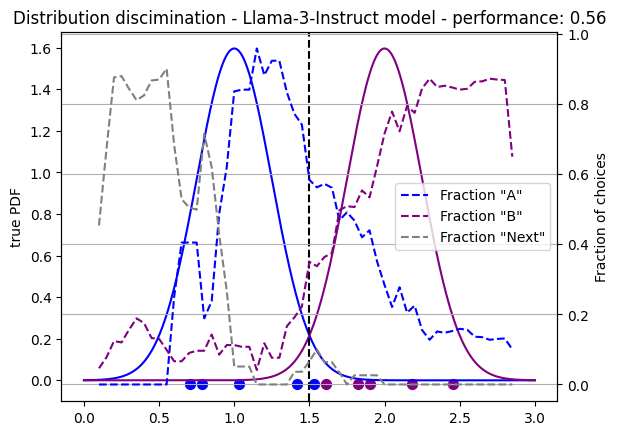

In [19]:
# convert the response fractions to numpy array
response_fractions_matrix = np.array(response_fractions)
# convert the testing samples to numpy array
testing_samples_vector = np.array(testing_samples)

# set number of rows
num_rows=response_fractions_matrix.shape[0]
# calculate the middle index
half_rows = num_rows // 2
# initialize a matrix of zeros with the same shape as the input
ideal_matrix = np.zeros((num_rows, 3))
# set the first half to [1, 0, 0]
ideal_matrix[:half_rows] = [1, 0, 0]
# Set the second half to [0, 1, 0]
ideal_matrix[half_rows:] = [0, 1, 0]
# compute performance metrics (fraction of correct responses)
performance = (response_fractions_matrix * ideal_matrix).sum(axis=1)     
# compute the average performance
average_performance = performance.mean()

# generating points for the Gaussian curves
x = np.linspace(0, 3, 1000)
gaussian_A = (1 / (dist_A['std'] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - dist_A['mean']) / dist_A['std'])**2)
gaussian_B = (1 / (dist_B['std'] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - dist_B['mean']) / dist_B['std'])**2)
# plotting the Gaussian curves
plt.plot(x, gaussian_A, label='Gaussian A', color='blue')
plt.plot(x, gaussian_B, label='Gaussian B', color='purple')
# plotting the samples
plt.scatter(samples_A, np.zeros_like(samples_A) - 0.02, color='blue', s=50, label='Samples A')
plt.scatter(samples_B, np.zeros_like(samples_B) - 0.02, color='purple', s=50, label='Samples B')
# plot dashed vertical line for ideal boundary
plt.axvline(x=1.5, color='black', linestyle='dashed')
plt.ylabel('true PDF')
# plotting the response fractions on another y-axis with dashed lines
plt.twinx()
plt.plot(testing_samples_vector, smooth_vector(response_fractions_matrix[:, 0],4), label='Fraction "A"', color='blue', linestyle='dashed')
plt.plot(testing_samples_vector, smooth_vector(response_fractions_matrix[:, 1],4), label='Fraction "B"', color='purple', linestyle='dashed')
plt.plot(testing_samples_vector, smooth_vector(response_fractions_matrix[:, 2],4), label='Fraction "Next"', color='gray', linestyle='dashed')
# adding labels and title
plt.xlabel('Value')
plt.ylabel('Fraction of choices')
plt.title('Distribution discimination - Llama-3-Instruct model - performance: {:.2f}'.format(average_performance))
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

In [115]:
# set the system message
system_message = "You are the llama-3-Instruct model. A large language model trained to generate text.\
        Giulio is the name of the person who set me up on this pc. I will work as a subject of Giulio's research."
# set the plain message for prompt 1
plain_message="What do you know about signal detection theory?"
prompt_1=prepare_tokenized_prompt(plain_message, system_message, text_generator)
# batch the prompts
prompts=[prompt_1]
# generate the completions for the batched prompts
completions=generate_response(prompts)
# get the cleaned responses in plain text
clean_responses=get_clean_response(completions)
# print the cleaned responses
for clean_response in clean_responses:
    print("----------------------   Response   ----------------------")
    print_response(clean_response) 
print("----------------------------------------------------------")

----------------------   Response   ----------------------
Signal detection theory! A fascinating topic in the realm of
psychology and neuroscience. As a knowledgeable llama-3-Instruct
model, I can provide you with an overview of this theory.  Signal
detection theory (SDT) is a mathematical framework used to analyze and
understand how people detect and respond to signals or stimuli in a
noisy environment. It was developed in the 1950s by psychologists and
mathematicians, primarily to study the detection of auditory and
visual signals.  The core idea of SDT is to understand how individuals
make decisions about the presence or absence of a signal, given the
uncertainty and variability of the environment. The theory assumes
that the detection process involves two types of errors:  1. False
alarms (Type I errors): The detection of a signal when none is
present. 2. Misses (Type II errors): The failure to detect a signal
when it is present.  SDT provides a mathematical framework to analyze
t